University of Tuebingen \
DataLiteracy course -  Group Project 2023/2024 \
Authors: Johannes Bertram, Felix Böhm, Nadja Buttke, Fabian Morelli 

# Project Figures for Visualizing impact of gain classes

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tueplots import bundles
from tueplots.constants.color import rgb

# Import data

In [2]:
gain_dict = {}
main_folder_path = '../dat/gain-comparison'
for foldername in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, foldername)

    folder_dict = {}
    print(foldername)

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            
            key_city = filename.split('_')[1].replace(".json", "")
            key_city = key_city.replace('ä', 'ae').replace('ö', 'oe').replace('ü', 'ue')

            df = pd.read_json(file_path, orient='index')
            df.index = df.index.str.replace('ä', 'ae').str.replace('ö', 'oe').str.replace('ü', 'ue')
            #print(key_city)
            folder_dict[key_city] = df
    
    gain_dict[foldername] = folder_dict
    

#print(dict_avg_gain['Berlin Hbf'])

zero_gain
no_wait
theoretical_max_gain
avg_gain
est_max_gain
avg_pos_gain


In [3]:
gain_dict['zero_gain']['Bremen Hbf'].head(2)

,switch time,date,delay,reachable
Muenchen Hbf,"[41.0, 41.0, 41.0, 7.0, 40.0, 43.0, 50.0, 53.0...","[2021-07-28 00:10:00, 2021-03-05 00:08:00, 202...","[3, 3, 0, -4.0, 0, 1, 134.0, 84, 109.0, 45, 23...","[3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, ..."
Saarbruecken Hbf,"[49.0, 41.0, 41.0, 41.0, 49.0, 19.0, 41.0, 41....","[2021-07-27 23:29:00, 2022-03-04 21:00:00, 202...","[0, 11, 0, 0, 0, 149.0, 149.0, 0, 0, 8, 0, 0, ...","[3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, ..."


# Mean Delay for each switch time and each gain type

In [5]:
dict_mean_delays = {}


# data processing

# iterate over different gain assumptions
for key_gain, df_dict in gain_dict.items():
    print(key_gain)


    switch_times_array = list(range(1,61,1))
    empty = pd.DataFrame(columns=['switch_times', 'mean_delay', 'reachable1', 'reachable2', 'reachable3'])
    empty.switch_times = switch_times_array
    empty['mean_delay'] = [[] for _ in range(60)]
    empty.loc[:, ['reachable1', 'reachable2', 'reachable3']] = 0

    #for column in ['mean_delay', 'reachable1', 'reachable2', 'reachable3']: # fill cells with empty lists such that later can fill with numbers
    #    empty[column] = [np.array([]) for _ in range(60)]
    #display(empty.head(2))

    # -------------------

    delay_matrix = [[] for _ in range(60)]

    # iterate all dfs in gain assumption
    for key, df in df_dict.items():
        
        #display(df.head(2))
        for irow, row in df.iterrows():
            
            #print(row)

            for i, minute in enumerate(row['switch time']):
                
        
                delay = row['delay'][i]
                #print(empty.loc[minute-1, 'mean_delay'])
                #print(type(empty.loc[minute-1, 'mean_delay']))


                #empty.loc[minute-1, 'mean_delay'].append(delay)
                delay_matrix[int(minute-1)].append(delay)

                #print(empty.loc[minute-1, 'mean_delay'])
                

                # Fill the reachable columns
                case = row['reachable'][i]
                if case == 1:
                    empty.loc[minute-1, 'reachable1'] += 1
                elif case == 2:
                    empty.loc[minute-1, 'reachable2'] += 1
                elif case == 3:
                    empty.loc[minute-1, 'reachable3'] += 1
                
                #display(empty)
                #break
    
            #break

    means = []
    #medians = []
    for minute in delay_matrix:
        means.append(np.mean(minute).round(2))
        #medians.append(np.median(minute).round(2))

    #print(means)
    empty['mean_delay'] = means
    #empty['median_delay'] = medians
    df_mean_delays = empty

    dict_mean_delays[key_gain] = df_mean_delays


zero_gain
no_wait
theoretical_max_gain
avg_gain
est_max_gain
avg_pos_gain


In [6]:
print(dict_mean_delays.keys())
dict_mean_delays['avg_gain'].head(2)

dict_keys(['zero_gain', 'no_wait', 'theoretical_max_gain', 'avg_gain', 'est_max_gain', 'avg_pos_gain'])


,switch_times,mean_delay,reachable1,reachable2,reachable3
0,1,59.79,166,32910,22337
1,2,45.70,164,41911,47733


### Plot

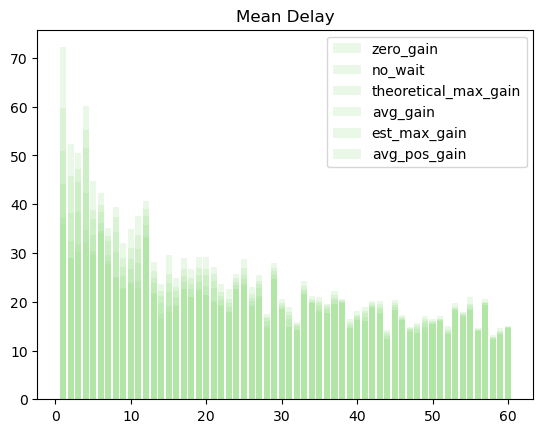

In [7]:
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update()
x = np.arange(len(df_mean_delays.switch_times))

fig, ax = plt.subplots()
for key, df in dict_mean_delays.items():

    ax.bar(x+1, df.mean_delay, label=key, color='#98DF8A', alpha=0.2)
#ax.bar(x+1, df_mean_delays.median_delay, label="median", color='#8C564B')

plt.legend()
plt.title('Mean Delay')

plt.show()

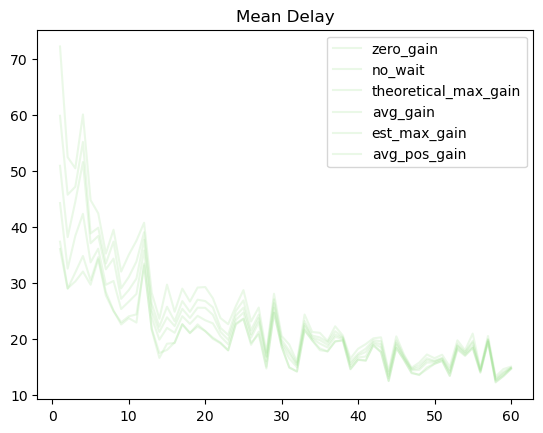

In [8]:
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update()
x = np.arange(len(df_mean_delays.switch_times))

fig, ax = plt.subplots()
for key, df in dict_mean_delays.items():

    ax.plot(x+1, df.mean_delay, label=key, color='#98DF8A', alpha=0.2)
#ax.bar(x+1, df_mean_delays.median_delay, label="median", color='#8C564B')

plt.legend()
plt.title('Mean Delay')

plt.show()

12
12
12
12
12
12
mean delay
['incoming train cancelled', 'outgoing train missed/cancelled', 'reached trains as planned', 'incoming train cancelled']


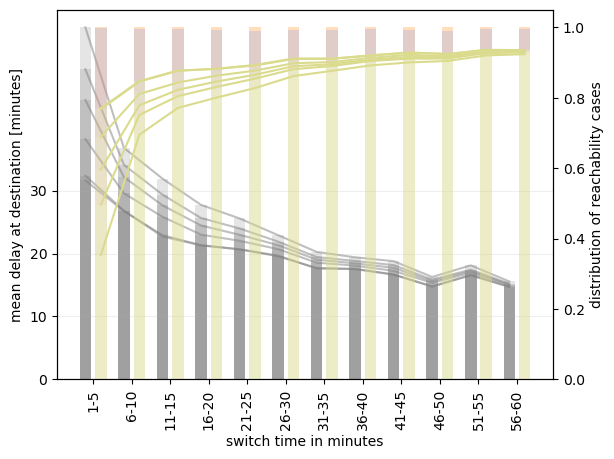

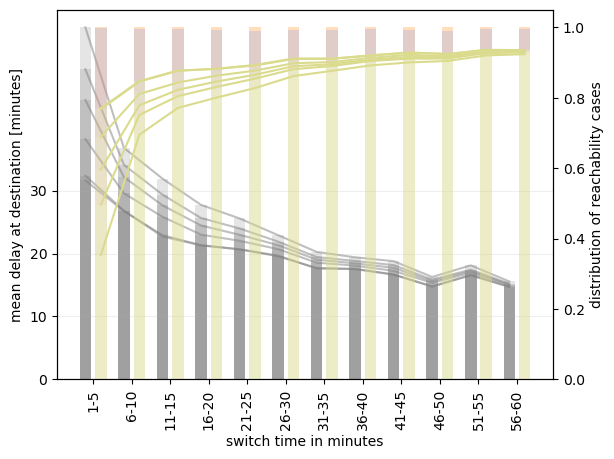

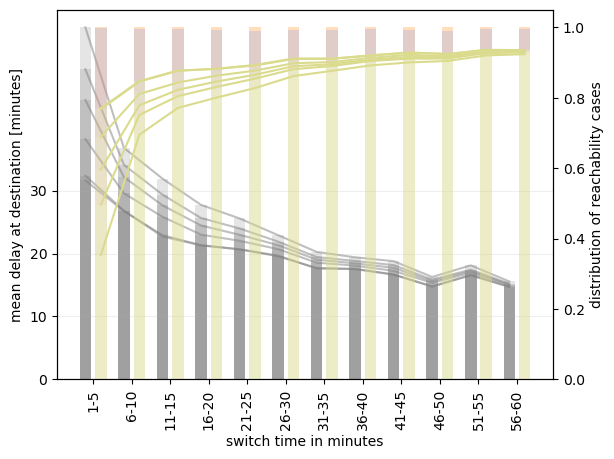

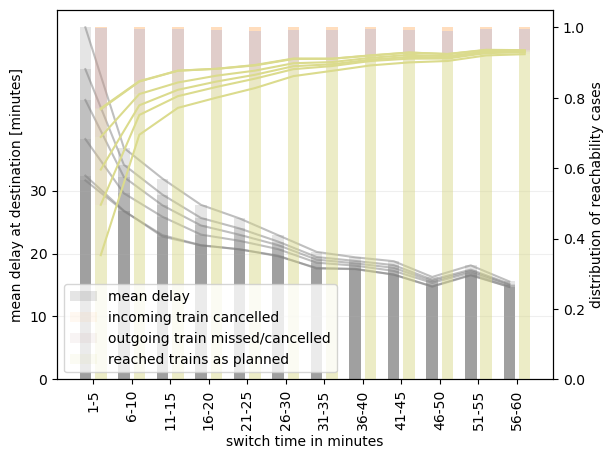

In [33]:
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.rcParams.update(plt.rcParamsDefault)
# Generate grouped Data

group_size = 5  # set group size 

# FIGURE ------------------------------

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


# iterate over gain assumptions
for key, df in dict_mean_delays.items():

    grouped_mean_delays = []
    #grouped_median_delays = []
    grouped_reachable1 = []
    grouped_reachable2 = []
    grouped_reachable3 = []

    for i in range(0, len(df.switch_times), group_size):
        group_sum_mean_delays = np.sum(df.mean_delay[i:i+group_size])
        grouped_mean_delays.append(group_sum_mean_delays)

        #group_sum_median_delays = np.sum(df.median_delay[i:i+group_size])
        #grouped_median_delays.append(group_sum_mean_delays)

        group_sum_reachable1 = np.sum(df.reachable1[i:i+group_size])
        grouped_reachable1.append(group_sum_reachable1)

        group_sum_reachable2 = np.sum(df.reachable2[i:i+group_size])
        grouped_reachable2.append(group_sum_reachable2)

        group_sum_reachable3 = np.sum(df.reachable3[i:i+group_size])
        grouped_reachable3.append(group_sum_reachable3)



    print(len(grouped_mean_delays))
    x = np.arange(len(grouped_mean_delays))

    y_ticks_array = np.arange(0, max(grouped_mean_delays)/group_size+1, 10)





    width = 0.3
    ax1.bar(x+1-0.2, np.array(grouped_mean_delays)/group_size, width, color="grey", label="mean delay", alpha=0.2)
    l1 = ax1.plot(x+1-0.2, np.array(grouped_mean_delays)/group_size, color="grey", alpha=0.5)
    #ax1.bar(x+1-0.2, np.array(grouped_median_delays)/group_size, width, color='black', alpha=0.2, label="median delay")

    #ax1.set_title('Mean Delay in Minutes and distribution of reachability cases \n depending on the switch time in minutes in Frankfurt Hbf \nusing subset data')
    ax1.set_xlabel('switch time in minutes')
    ax1.set_ylabel('mean delay at destination [minutes]')
    xticks_array =  [f'{start}-{end}' for start, end in zip(range(1, 60, group_size), range(1 + group_size - 1, 60 + 1, group_size))]
    ax1.set_xticks(x+1, xticks_array, rotation=90)
    ax1.set_yticks(y_ticks_array)
    ax1.yaxis.grid("major", alpha=0.2)



    

    bottom = np.zeros(len(grouped_mean_delays))

    reachables_total = np.array(grouped_reachable1) + np.array(grouped_reachable2) + np.array(grouped_reachable3)
    bar1 = np.array(grouped_reachable1)/reachables_total
    bar2 = np.array(grouped_reachable2)/reachables_total
    bar3 = np.array(grouped_reachable3)/reachables_total

    ax2.bar(x+1+0.2, bar1, width, color="#FFBB78", label="incoming train cancelled", bottom=bottom+bar2+bar3, alpha=0.1)
    #ax2.plot(x+1+0.2, bar1+bar2+bar3, color="#FFBB78")
    ax2.bar(x+1+0.2, bar2, width, color="#C49C94", label="outgoing train missed/cancelled", bottom=bottom+bar3, alpha=0.1)
    #ax2.plot(x+1+0.2, bar2+bar3, color="#C49C94")
    ax2.bar(x+1+0.2, bar3, width, color="#DBDB8D", label="reached trains as planned", bottom=bottom, alpha=0.1)
    l2 = ax2.plot(x+1+0.2, bar3, color="#DBDB8D")
    #ax2.set_yscale()
    ax2.set_ylabel('distribution of reachability cases')


# Solution for having two legends
bars1, labels1 = ax1.get_legend_handles_labels()
bars2, labels2 = ax2.get_legend_handles_labels()

#print(labels1[0])
#print(labels2[0:4])
ax2.legend([bars1[0]] + bars2[0:3], [labels1[0]] + labels2[0:3], loc="lower left")
    
#ax2.legend(handles=[l1, l2])

plt.savefig("plot_meanDelay_gain.pdf", format="pdf")

plt.show()